# Problem 1: K-means clustering and image compression (3pts)

### <div align="right"> &copy; Markiian Novosad & Rostyslav Hryniv, 2022 </div>

## Completed by:   
*   First team member
*   Second team member



### Description:
The aim of this assignment is to understand the K-means clustering algorithm and how it is used for image compression. You will implement the algorithm and then use it to assign the $m\times m$ blocks of the given image in $k$ clusters and then replace each block with the respective centroid. Visually, the quality of the image does not deteriorate much for moderate $m$ and large enough $k$, while its size drops down significantly as we only have to store the $k$ centroids and the cluster allocations of the blocks


### Links
For this task of your homework you can get **3 points** plus extra (see the last part). Do not forget to save and rename the notebook before making any changes!


To do some preliminary reading about K-Means algorithm, please check the following links:
*   https://scikit-learn.org/stable/modules/clustering.html
*   https://towardsdatascience.com/image-compression-using-k-means-clustering-aa0c91bb0eeb


### Initialization

In [359]:
from PIL import Image
import requests
from io import BytesIO

url = "https://images.unsplash.com/photo-1611915387288-fd8d2f5f928b?ixlib=rb-4.0.3&w=1080&fit=max&q=80&fm=jpg&crop=entropy&cs=tinysrgb"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [360]:
import torch
import numpy as np
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [361]:
def to_patches(img: torch.Tensor, psize) -> np.ndarray:
  return img.unfold(1, size=psize, step=psize).unfold(2, size=m, step=m).flatten(1,2).permute(1,0,2,3).numpy()

def visualize_patches(patches: np.ndarray, true_image_size=512, padding=0) -> Image:
  patch_tensor = torch.from_numpy(patches)
  return Image.fromarray(
      make_grid(patch_tensor, nrow=true_image_size // patches.shape[2], padding=padding
                ).permute(1,2,0).mul(255).to(torch.uint8).numpy())

## 1. K-Means Clustering from scratch (1 pt)

In this part, you will have to implement K-Means clustering algorithm for a dataset of points in $\mathbb{R}^n$. To this end, you are asked to implement the following methods:

*   random centroid initialization (choose random dataset points)
*   distance function
      *   Implement private methods with different distance metric (Euclidean, $\ell_1$, cosine, etc.)
*   allocation of points to clusters for given centroids
*   centroids update based on distance to all data points in respective clusters
*   and, finally, implement K-Means fitting loop, wich returns new fitted centroids





### Task 1: Complete the code below

In [387]:
import random
# from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt 

np.random.seed(128)

class KMeans:

  def __init__(
      self,
      num_clusters=1,
      num_features=1,
      max_iter=1000,
      epsilon=1e-6,
      dist_metric="euclidean"
    ) -> None:
    self.K = num_clusters
    self.C = num_features
    self.I = max_iter
    self.E = epsilon
    self.metric = dist_metric

  def init_centroids(self, X: np.ndarray) -> np.ndarray:
    """
    Initialize centroids in random manner
    """
    assert (self.C) == X.shape[1]
    # centroids = np.zeros((self.K, self.C))
    # ========= YOUR CODE STARTS HERE ========= #

    num_clust = self.K if self.K <= X.shape[0] else X.shape[0]

    rng = np.random.default_rng(seed=128)
    idx = rng.choice(X.shape[0], size=num_clust, replace=False)

    centroids = X[idx, :]

    # ========== YOUR CODE ENDS HERE ========== #
    return centroids

  def dist(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance from each point to each centroid,
    depending on a self.metric type
    """
    # ========= YOUR CODE STARTS HERE ========= #

    match self.metric:
      case "euclidian":
        d_temp = np.array([[x - c for c in centroids] for x in X])
        d = np.apply_along_axis(lambda x: np.sqrt(np.sum(x**2)), 2, d_temp)
      case "cosine":
        d = 1 - np.array([[np.sum((x * c)) / np.sqrt(np.sum(x**2)*np.sum(c**2)) for c in centroids] for x in X])
      case "l1":
        d = np.array([[np.sum(np.abs(x - c)) for c in centroids] for x in X])
      case _:
        raise NotImplementedError

    return d

    # ========== YOUR CODE ENDS HERE ========== #


  def calc_mask(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute distance between data and centroids, pick closest centroid for each
    data point.
    """
    return self.dist(X, centroids).argmin(-1)

  def update_clusters(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Compute new centroids, by computing the mean of each centroid's cluster.

    Hint: Beware, with high value of K, some clusters centroid's can become
    redundant, and have no points belonging to them.
    """
    mask = self.calc_mask(X, centroids)
    # new_centroids = np.zeros_like(centroids)

    # ========= YOUR CODE STARTS HERE ========= #

    new_centroids_temp = map(lambda k: X[mask == k].mean(axis = 0), set(mask))

    new_centroids = np.array(list(new_centroids_temp))

    # ========== YOUR CODE ENDS HERE ========== #

    return new_centroids

  def predict(self, X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    mask = self.calc_mask(X, centroids)
    return centroids[mask]

  def fit(self, X: np.ndarray) -> np.ndarray:
    """
    Implement training loop that looks like this:
    -- intiialize new centroids
    -- for max_iter steps:
      -- update centroids
      -- compute delta between old and new centroids
      -- return centroids if delta < epsilon

    """
    # ========= YOUR CODE STARTS HERE ========= #

    old_centroids = self.init_centroids(X)

    for i in range(0, self.I):

      new_centroids = self.update_clusters(X, old_centroids)

      delta = np.sqrt(np.sum((new_centroids - old_centroids[0:new_centroids.shape[0]])**2))

      if (delta < self.E):
        return(new_centroids)
      
      old_centroids = new_centroids

    # ========== YOUR CODE ENDS HERE ========== #


## 2. Image compression using K-Means clustering (0.5 pt)

The dataset for clustering will be the $m\times m$ patches of the initial image. We split the image into patches with helper function **to_patches()**

In [363]:
m = 16 # size of patch
img = img.resize((512,512))
img_tensor = ToTensor()(img) # 3, 512, 512

patches = to_patches(img_tensor, m)
patches.shape

(1024, 3, 16, 16)

Let's see how our splitted image looks:
(You can change padding from 0 to another value, to see the grid)

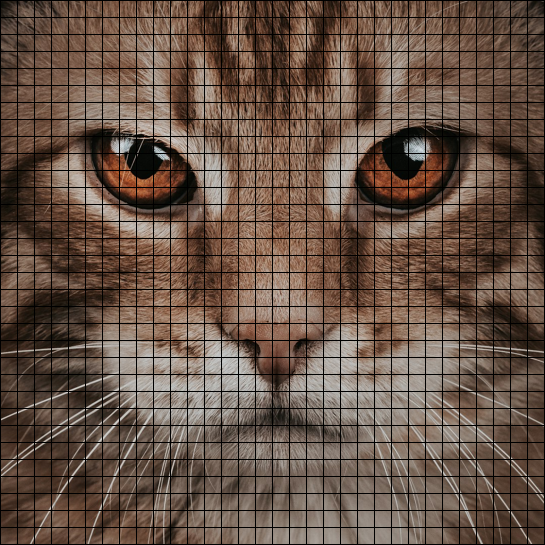

In [364]:
visualize_patches(patches, padding=1)

In [365]:
# convert patch data to feature vectors
data = patches.reshape(patches.shape[0], -1)
data.shape

(1024, 768)

### Try out your implementation!

In [366]:
kmeans = KMeans(800, data.shape[-1], max_iter=10000, dist_metric = "cosine")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
image_cos = visualize_patches(predicted.reshape(-1,3,m,m))

kmeans = KMeans(800, data.shape[-1], max_iter=10000, dist_metric = "euclidian")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
image_l2 = visualize_patches(predicted.reshape(-1,3,m,m))

kmeans = KMeans(800, data.shape[-1], max_iter=10000, dist_metric = "l1")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
image_l1 = visualize_patches(predicted.reshape(-1,3,m,m))

### Task 2: Discussion (0.5 pt)

 Using the implemented image compression algorithm, discuss the following topics:
1.  **Distance Metrics**: how do they influence of distance metrics on final result of fitting? (Provide visualizations and comments)
2.  **Compression rate**: what is the compression rate with different **k** (1,2,...,32) and **m**? What compression rate can we achieve without losing much quality?


---

\### **YOUR ANSWER HERE** \###

---

1. It seems to me that euclidian metric is the best, L1 is in the middle and cosine is the worst in terms of resulting image quality. But all distance metrics work well and achieve higher compression for larger K and m.

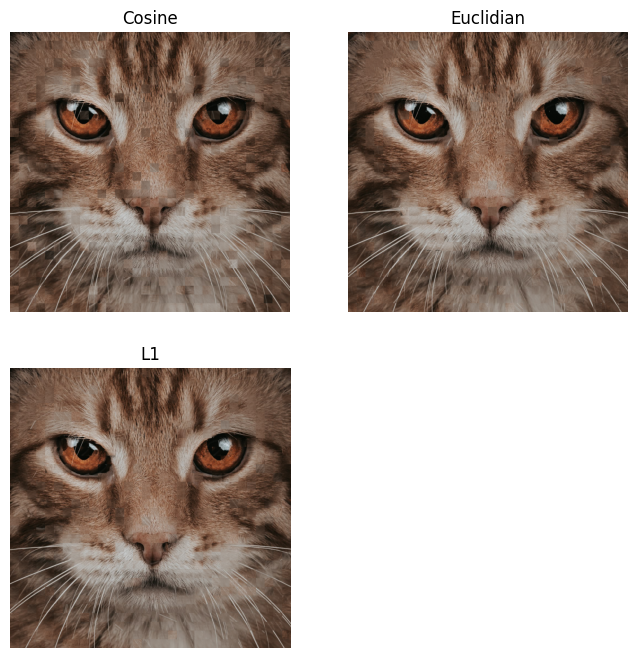

In [367]:
plt.figure(figsize=(8,8))

plt.subplot(2, 2, 1)
plt.imshow(image_cos)
plt.axis("off")
plt.title("Cosine")

plt.subplot(2, 2, 2)
plt.imshow(image_l2)
plt.axis("off")
plt.title("Euclidian")

plt.subplot(2, 2, 3)
plt.imshow(image_l1)
plt.axis("off")
plt.title("L1")

plt.show()

2. The dimension of data required to store an image before compression was equal to $n\cdot m \cdot m\cdot 3$. After compression it is equal to $k\cdot m\cdot m\cdot 3 + n$. It can be noticed that n is a function of m: $n = \displaystyle\frac{512\cdot 512}{m^2}$. Therefore, the compression rate equals to $\displaystyle\frac{n\cdot m \cdot m\cdot 3}{k\cdot m\cdot m\cdot 3 + n} = \displaystyle\frac{512^2\cdot3}{k\cdot m^2\cdot 3 + \displaystyle\frac{512^2}{m^2}}$.

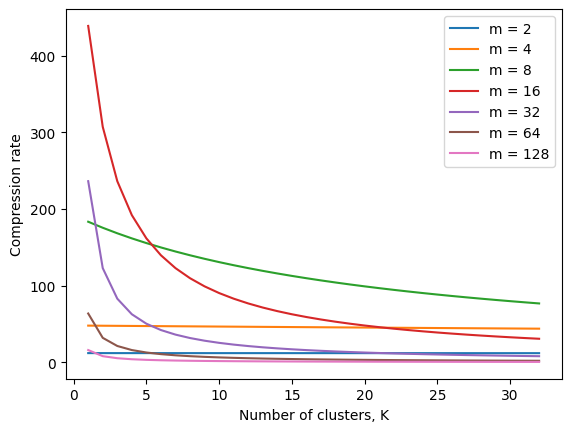

In [369]:
def CR(m, k):
    return 512**2*3 / (k*m**2*3 + 512**2/m**2)

K = np.arange(33)[1:]
M = 2**np.arange(8)[1:]

CR = np.vectorize(CR)

CR_arr = np.array([[CR(m, k) for k in K] for m in M])
CR_arr.shape

for i, j in zip(range(CR_arr.shape[0]), M):
    plt.plot(K, CR_arr[i, :], label=f"m = {j}")

plt.xlabel("Number of clusters, K")
plt.ylabel("Compression rate")
plt.legend()
plt.show()


## 3. Elbow method (1 pt)

In this task, we will use the Elbow method to visualize the trade-off between quality and number of clusters $k$ and try to select the best one!

##### To do some preliminary reading about Elbow Method, please, check the following link:
- https://stackabuse.com/k-means-clustering-with-the-elbow-method/

### Task 3: Implementation (0.3 pt)
Here we will implement the calculation of **Distortion** or **Inertia**, which are basically squared distances from each point to its assigned centroid.

In [370]:
## For each k run clustering algorithm and compute it's Distortion value
def calc_distoriton(data: np.ndarray, centroids:np.ndarray, kmeans_obj:KMeans) -> float:
    # distortion = 0
    # ========= YOUR CODE STARTS HERE ========= #
    centroids_assigned = kmeans_obj.predict(data, centroids)
    distortion = ((data - centroids_assigned)**2).sum()
    # ========== YOUR CODE ENDS HERE ========== #
    return distortion

### Task 4: Calculate & Visualize (0.4 pt)
Let's use above implemented function to calculate distortion for some $k$ values and visualize our results

In [390]:
# You can choose your own values for the range
#(it may take some time to run the loop, so feel free to optimize your code ;=)
k_min = 2
k_max = 64
k_range = range(k_min, k_max, 2)

distortions = list()
#calculate distortion values
for k in k_range:
  # ========= YOUR CODE STARTS HERE ========= #

  kmeans = KMeans(k, data.shape[-1], max_iter=10000, dist_metric = "euclidian")
  centroids = kmeans.fit(data)  
  distortion = calc_distoriton(data=data, centroids = centroids, kmeans_obj=kmeans)
  distortions.append(distortion)
  # ========== YOUR CODE ENDS HERE ========== #

Text(0.5, 1.0, 'Elbow method for 16x16 blocks')

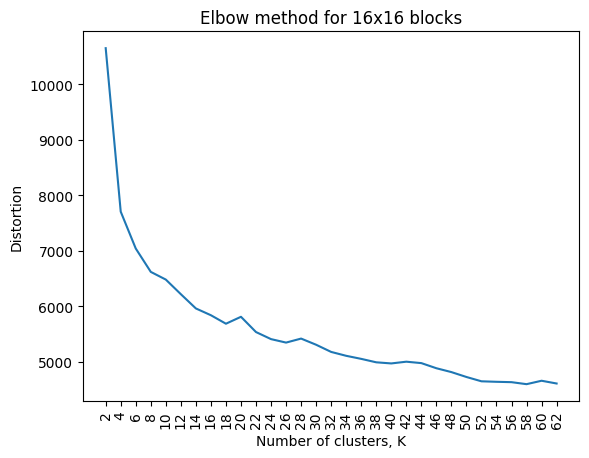

In [389]:
distortions = np.array(distortions)

plt.plot(k_range, distortions)
plt.xticks(k_range, rotation=90)
plt.xlabel("Number of clusters, K")
plt.ylabel("Distortion")
plt.title("Elbow method for 16x16 blocks")

### Task 5: Summarize (0.3 pt)

Discuss your results: what is the best trade-off between number of clusters and distortion?

What is the compression rate with this optimal value?

The elbow pattern (where the decrease of distortion slows significantly) occurs at K = 16.

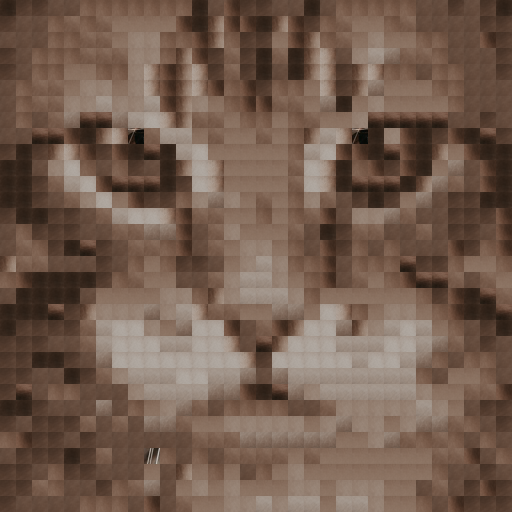

In [392]:
kmeans = KMeans(16, data.shape[-1], max_iter=10000, dist_metric = "euclidian")
centroids = kmeans.fit(data)
predicted = kmeans.predict(data, centroids)
image = visualize_patches(predicted.reshape(-1,3,m,m))
image

In [406]:
cr = (CR(16, 16))
print(f"The compression rate with k = 16 and m = 16 equals to {int(cr)}")

The compression rate with k = 16 and m = 16 equals to 59


---

\### **YOUR ANSWER HERE** \###

---

## 4. Conclusions (0.5 pt)

---


### Task 6 (0.5 pt)
Summarize in a few sentences what you have learned and achieved by completing the tasks of this assignment

---

\### **YOUR ANSWER HERE** \###

---

We have learned to perform a k-means clustering which starts with randomly chosen mxm blocks as centroids, updates them to new centroids by averaging the closest to each centroid blocks, and repeats this step till convergance. Also we've learned how to represent images as numpy arrays, use broadcasting and other features of the numpy library to write simple and efficient code.

## 5. Bonus Problem (0.5 pt)
Besides compression, K-Means clustering can be used in more "creative" way -- using bigger patch sizes we can create cool "pop-art" mosaics :=)

*Hint*: you can replace fitted centroids with your own patches.

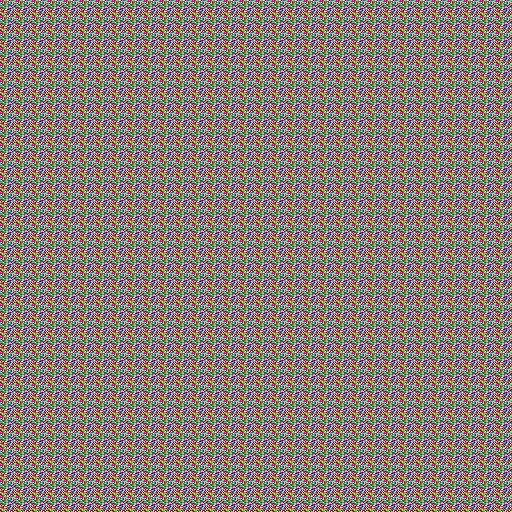

In [419]:
# ========= YOUR CODE STARTS HERE ========= #
centroids = np.random.randn(kmeans.K, 3*m*m)
predicted = kmeans.predict(data, centroids)
image = visualize_patches(predicted.reshape(-1,3,m,m))
image
# ========== YOUR CODE ENDS HERE ========== #